# NAML project - Stroke prediction
###  Cavallini - Eusebio

In [253]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [254]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [255]:
new_cols = ["id", "gender", "age", "hypertension", "heart-disease", "ever-married", "work-type", "Residence-type", "avg-glucose-level", "bmi", "smoking-status", "stroke"]

cathegorical_features = ['work-type', 'smoking-status']
binary_features = ['hypertension', 'heart-disease', 'gender', 'ever-married', 'Residence-type']
numerical_features = ['age', 'avg-glucose-level', 'bmi']

df.columns = new_cols

In [256]:
df.head()

,id,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [257]:
df.drop('id', axis=1, inplace=True) # drop id column because it is not useful

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart-disease      5110 non-null   int64  
 4   ever-married       5110 non-null   object 
 5   work-type          5110 non-null   object 
 6   Residence-type     5110 non-null   object 
 7   avg-glucose-level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking-status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


## Data Pre-processing

In [259]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart-disease          0
ever-married           0
work-type              0
Residence-type         0
avg-glucose-level      0
bmi                  201
smoking-status         0
stroke                 0
dtype: int64

In [260]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart-disease          0
ever-married           0
work-type              0
Residence-type         0
avg-glucose-level      0
bmi                  201
smoking-status         0
stroke                 0
dtype: int64

In [261]:
bmi_strokes = df[df['bmi'].isnull()]['stroke'].value_counts()
stroke_count = df['stroke'].value_counts()
print(bmi_strokes)

stroke
0    161
1     40
Name: count, dtype: int64


In [262]:
print("Percent of null values accounting for strokes ", 100*bmi_strokes[1]/stroke_count[1])

Percent of null values accounting for strokes  16.06425702811245


In [263]:
df = df[df['age'] >= 18]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4254 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4254 non-null   object 
 1   age                4254 non-null   float64
 2   hypertension       4254 non-null   int64  
 3   heart-disease      4254 non-null   int64  
 4   ever-married       4254 non-null   object 
 5   work-type          4254 non-null   object 
 6   Residence-type     4254 non-null   object 
 7   avg-glucose-level  4254 non-null   float64
 8   bmi                4073 non-null   float64
 9   smoking-status     4254 non-null   object 
 10  stroke             4254 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 398.8+ KB


The amount of strokes in the dataset is very low, so the BMI null values account for 20% of the dataset. Dropping is therefore not an option

In [264]:
df['bmi'].fillna(df['bmi'].mean(), inplace=True) # fill missing values in bmi column with the mean of the column

C:\Users\hp\AppData\Local\Temp\ipykernel_10416\2820060641.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace=True) # fill missing values in bmi column with the mean of the column


In [265]:
df['smoking-status'].value_counts()

smoking-status
never smoked       1752
Unknown             862
formerly smoked     860
smokes              780
Name: count, dtype: int64

In [266]:
unknown_smokers_stroke = df[(df['smoking-status'] == 'Unknown') & (df['stroke'] == 1)].shape[0]
stroke_count = df[df['stroke'] == 1].shape[0]

In [267]:
print(f"Number of unknown smoking status people who had a stroke: {unknown_smokers_stroke/stroke_count*100:.2f}%")

Number of unknown smoking status people who had a stroke: 18.22%


Since the Unknown category in smoking-status is present in 13.46%, dropping it as it was done in the paper may lead to a significant loss of information. In this version we have decided to use a RandomForestClassifier to predict the missing values in the smoking-status column. We will use the other columns as features to predict the missing values. 

In [268]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Assume df contains other features that are useful for prediction
# Separate known and unknown data
df_known = df[df['smoking-status'] != 'Unknown'].drop('stroke', axis=1)
df_unknown = df[df['smoking-status'] == 'Unknown'].drop('stroke', axis=1)

# Prepare data for training
X_known = df_known.drop('smoking-status', axis=1)  # Other features
y_known = df_known['smoking-status']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), ['work-type']),
        ('bin', OrdinalEncoder(), binary_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
    ])

model = pipeline.fit(X_known, y_known)

# Predict missing values
X_unknown = df_unknown.drop('smoking-status', axis=1)
df.loc[df['smoking-status'] == 'Unknown', 'smoking-status'] = model.predict(X_unknown)

In [269]:
df.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.432752,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [270]:
df.describe()

,age,hypertension,heart-disease,avg-glucose-level,bmi,stroke
count,4254.000000,4254.000000,4254.000000,4254.000000,4254.000000,4254.000000
mean,50.202163,0.116831,0.064645,108.514394,30.432752,0.058063
std,17.829035,0.321257,0.245927,47.769400,7.079512,0.233890
min,18.000000,0.000000,0.000000,55.120000,11.300000,0.000000
25%,36.000000,0.000000,0.000000,77.482500,25.600000,0.000000
50%,50.500000,0.000000,0.000000,92.465000,29.600000,0.000000
75%,64.000000,0.000000,0.000000,116.135000,33.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,92.000000,1.000000


In the paper the missing nan values were removed, in this version a better practice would be to impute their values with the mean of the column. This is done in the following code.

In [271]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart-disease        0
ever-married         0
work-type            0
Residence-type       0
avg-glucose-level    0
bmi                  0
smoking-status       0
stroke               0
dtype: int64

In the paper is clearly stated that only the patients above 18 years old were considered. We have removed the patients below 18 years old.

In [272]:
df['smoking-status'].value_counts()

smoking-status
never smoked       2393
formerly smoked     989
smokes              872
Name: count, dtype: int64

In [273]:
df.loc[df['gender'] == 'Other', 'gender'] = 'Female'
df['gender'].value_counts()

gender
Female    2577
Male      1677
Name: count, dtype: int64

In the paper the 'Other' label was removed, instead we have decided to impute the missing values with the most frequent value of the column.

In [274]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4254 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4254 non-null   object 
 1   age                4254 non-null   float64
 2   hypertension       4254 non-null   int64  
 3   heart-disease      4254 non-null   int64  
 4   ever-married       4254 non-null   object 
 5   work-type          4254 non-null   object 
 6   Residence-type     4254 non-null   object 
 7   avg-glucose-level  4254 non-null   float64
 8   bmi                4254 non-null   float64
 9   smoking-status     4254 non-null   object 
 10  stroke             4254 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 398.8+ KB


We filter out also the patients whose gender and smoking status are unknown. This to reducce the uncertainty in the data.

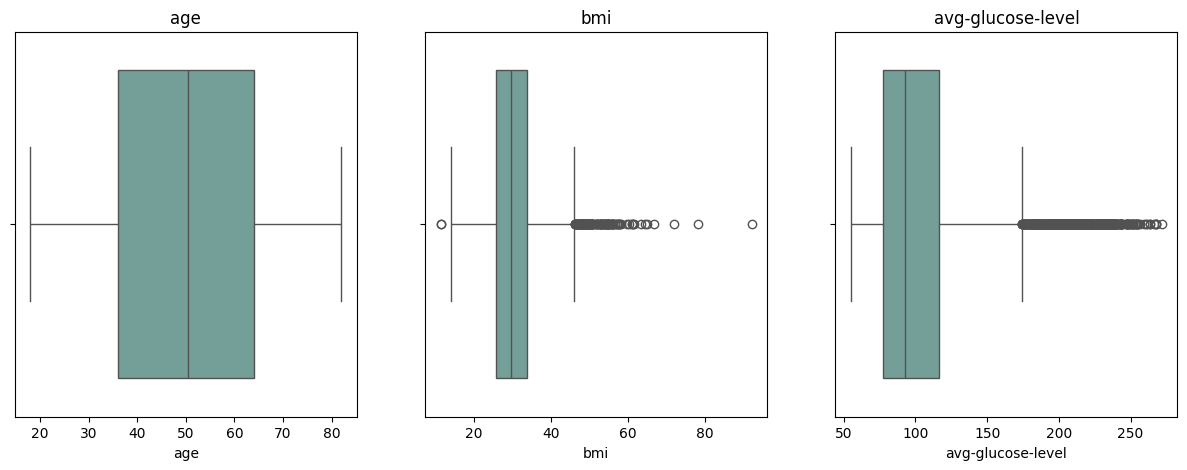

In [275]:
num_cols = ['age','bmi','avg-glucose-level']

plt.figure(figsize=(15, 5))
for i in range(3) :
    plt.subplot(1,3,i+1)

    sns.boxplot(x=df[num_cols[i]],color='#6DA59D')
    plt.title(num_cols[i])
plt.show()

In the paper, the autors have removed the single lowest bmi value. We are going to filter the outliers using the inter-quartile method.

In [276]:
for col in ['bmi', 'avg-glucose-level']:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3562 entries, 2 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3562 non-null   object 
 1   age                3562 non-null   float64
 2   hypertension       3562 non-null   int64  
 3   heart-disease      3562 non-null   int64  
 4   ever-married       3562 non-null   object 
 5   work-type          3562 non-null   object 
 6   Residence-type     3562 non-null   object 
 7   avg-glucose-level  3562 non-null   float64
 8   bmi                3562 non-null   float64
 9   smoking-status     3562 non-null   object 
 10  stroke             3562 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 333.9+ KB


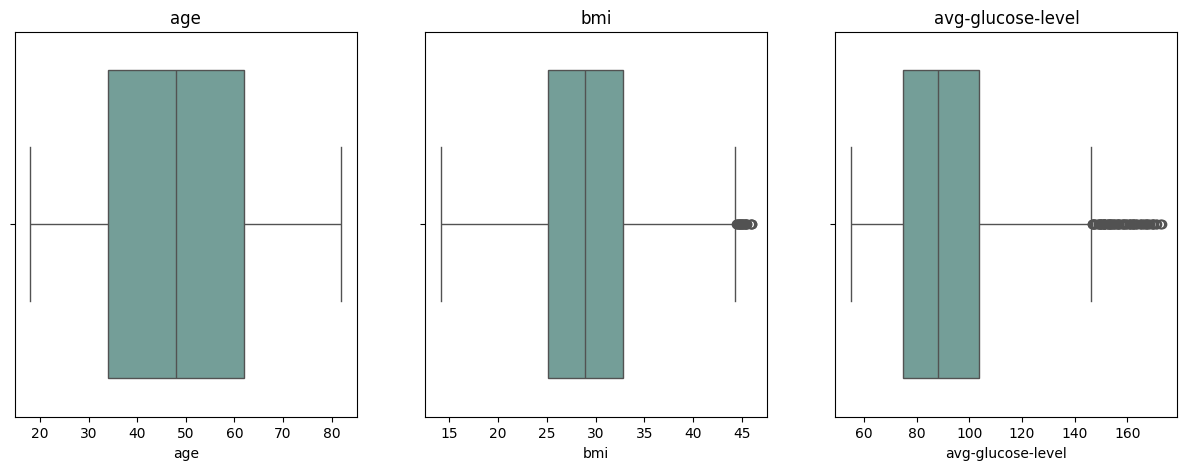

In [278]:
num_cols = ['age','bmi','avg-glucose-level']

plt.figure(figsize=(15, 5))
for i in range(3) :
    plt.subplot(1,3,i+1)

    sns.boxplot(x=df[num_cols[i]],color='#6DA59D')
    plt.title(num_cols[i])
plt.show()

## Exploratory Data Analysis

In [279]:
stroke_count =df['stroke'].value_counts() # pandas serie, it contains the number of '1' (stroke) and the number of '0' (no stroke)
print("Stroke percentage: {:.2f}%".format(100 * (stroke_count[1] / (stroke_count[0] + stroke_count[1]))))

Stroke percentage: 4.63%


In [280]:
gender_count = df['gender'].value_counts()
print('Number of males: ', gender_count['Male'])
print('Number of females: ', gender_count['Female'])

Number of males:  1376
Number of females:  2186


In [281]:
hypertension_count =df['hypertension'].value_counts()
print("Hypertension percentage: {:.2f}%".format(100 *( hypertension_count[1]/(hypertension_count[0]+hypertension_count[1]))))

Hypertension percentage: 9.21%


In [282]:
heart_disease_count =df['heart-disease'].value_counts()
print("Hearth disease percentage: {:.2f}%".format(100 * (heart_disease_count[1]/(heart_disease_count[0]+heart_disease_count[1]))))

Hearth disease percentage: 4.86%


In [283]:
ever_married_count =df['ever-married'].value_counts()
print("Married percentage: {:.2f}%".format(100 * (ever_married_count[0]/(ever_married_count[0]+ever_married_count[1]))))

Married percentage: 76.92%


C:\Users\hp\AppData\Local\Temp\ipykernel_10416\140164340.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Married percentage: {:.2f}%".format(100 * (ever_married_count[0]/(ever_married_count[0]+ever_married_count[1]))))


In [284]:
work_type_count =df['work-type'].value_counts()
print("Private percentage: {:.2f}%".format(100 * (work_type_count[0]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))))
print("Self-employed percentage: {:.2f}%".format(100 * (work_type_count[1]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))))
print("Gov percentage: {:.2f}%".format(100 * (work_type_count[2]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))))
print("Never Worked fraction: {:.1f}%".format(100 * (work_type_count[3]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))))

Private percentage: 66.25%
Self-employed percentage: 18.30%
Gov percentage: 15.30%
Never Worked fraction: 0.1%


C:\Users\hp\AppData\Local\Temp\ipykernel_10416\2819490883.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Private percentage: {:.2f}%".format(100 * (work_type_count[0]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))))
C:\Users\hp\AppData\Local\Temp\ipykernel_10416\2819490883.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Self-employed percentage: {:.2f}%".format(100 * (work_type_count[1]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))))
C:\Users\hp\AppData\Local\Temp\ipykernel_10416\2819490883.py:4: FutureWarning: Series.__getitem__ 

In [285]:
residence_type_count =df['Residence-type'].value_counts()
print("Urban percentage: {:.2f}%".format(100 * (residence_type_count[0]/(residence_type_count[0]+residence_type_count[1]))))
print("Rural pergentage: {:.2f}%".format(100 * (residence_type_count[1]/(residence_type_count[0]+residence_type_count[1]))))

Urban percentage: 50.93%
Rural pergentage: 49.07%


C:\Users\hp\AppData\Local\Temp\ipykernel_10416\159459921.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Urban percentage: {:.2f}%".format(100 * (residence_type_count[0]/(residence_type_count[0]+residence_type_count[1]))))
C:\Users\hp\AppData\Local\Temp\ipykernel_10416\159459921.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Rural pergentage: {:.2f}%".format(100 * (residence_type_count[1]/(residence_type_count[0]+residence_type_count[1]))))


In [286]:
smoking_status_count =df['smoking-status'].value_counts()
print("Never Smoked fraction: {:.2f}%".format(100 * (smoking_status_count[0]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))))
print("Formely Smoked fraction: {:.2f}%".format(100 * (smoking_status_count[1]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))))
print("Smokes fraction: {:.2f}%".format(100 * (smoking_status_count[2]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))))

Never Smoked fraction: 57.24%
Formely Smoked fraction: 22.01%
Smokes fraction: 20.75%


C:\Users\hp\AppData\Local\Temp\ipykernel_10416\4037653718.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Never Smoked fraction: {:.2f}%".format(100 * (smoking_status_count[0]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))))
C:\Users\hp\AppData\Local\Temp\ipykernel_10416\4037653718.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Formely Smoked fraction: {:.2f}%".format(100 * (smoking_status_count[1]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))))
C:\Users\hp\AppData\Local\Temp\ipykernel_10416\4037653718.py:4: FutureWarning: Series.__getite

The percentages showed above are exactly the same as the ones in the paper.

In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3562 entries, 2 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3562 non-null   object 
 1   age                3562 non-null   float64
 2   hypertension       3562 non-null   int64  
 3   heart-disease      3562 non-null   int64  
 4   ever-married       3562 non-null   object 
 5   work-type          3562 non-null   object 
 6   Residence-type     3562 non-null   object 
 7   avg-glucose-level  3562 non-null   float64
 8   bmi                3562 non-null   float64
 9   smoking-status     3562 non-null   object 
 10  stroke             3562 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 333.9+ KB


In [288]:
df.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status,stroke
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.400000,never smoked,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.800000,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,30.432752,formerly smoked,1


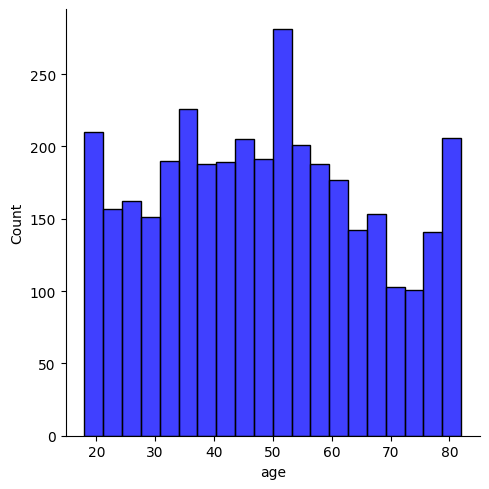

In [289]:
sns.displot(df['age'], bins=20, kde=False, color='blue')

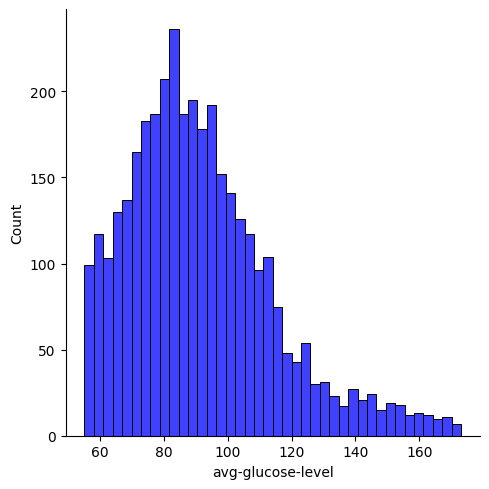

In [290]:
sns.displot(df['avg-glucose-level'], bins=40, kde=False, color='blue')

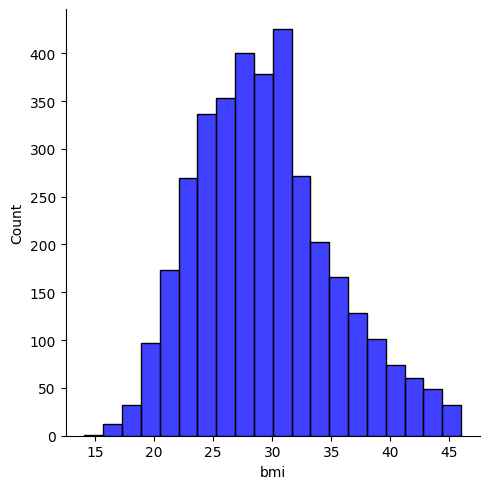

In [291]:
sns.displot(df['bmi'], bins=20, kde=False, color='blue')

### Oversampling

In [292]:
features = np.array(df.columns[:-1])
print(features)

X = df.drop(['stroke'], axis = 1) # Data
y = df['stroke'] # Target

['gender' 'age' 'hypertension' 'heart-disease' 'ever-married' 'work-type'
 'Residence-type' 'avg-glucose-level' 'bmi' 'smoking-status']


In [293]:
y.value_counts()

stroke
0    3397
1     165
Name: count, dtype: int64

<AxesSubplot:ylabel='count'>

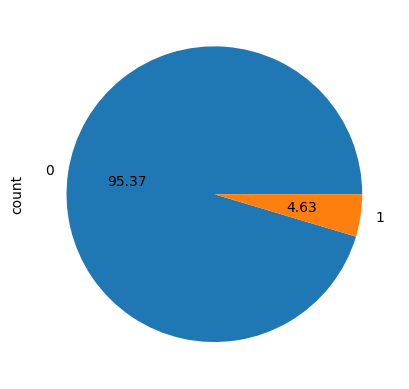

In [294]:
y.value_counts().plot.pie(autopct = "%.2f")

We can clearly see that there is a disproportion between the number of smokers and non-smokers. This is a problem because the model could be biased towards the non-smokers. We will try to balance the dataset by oversampling the smokers.

In [295]:
X.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.400000,never smoked
7,Female,69.0,0,0,No,Private,Urban,94.39,22.800000,never smoked
8,Female,59.0,0,0,Yes,Private,Rural,76.15,30.432752,formerly smoked


Train-Test Split

It is usually recommended to perform the oversampling only on the train dataset, therefore we will split the dataset into train and test and then oversample the train dataset.

In [296]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) # the data is split into 80% training and 20% testing randomly

In [297]:
X_train.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status
4608,Male,59.0,0,0,Yes,Private,Rural,69.37,26.9,formerly smoked
257,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes
34,Male,48.0,0,0,No,Govt_job,Urban,84.20,29.7,never smoked
1743,Male,37.0,0,0,Yes,Private,Urban,79.56,25.2,never smoked
4478,Male,40.0,0,0,Yes,Self-employed,Rural,65.29,28.3,never smoked


Applying the oversampling SMOTE technique. In the paper the authors have oversampled the whole dataset, we will oversample only the train dataset.

Moreover we will use a different version of SMOTE, the SMOTENC, which is more suitable for datasets with categorical features.

In [298]:
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.preprocessing import OrdinalEncoder, RobustScaler

X_tmp = X_train.copy()
y_tmp = y_train.copy()

# Apply SMOTE
smote = SMOTENC(sampling_strategy='minority', categorical_features=['work-type', 'smoking-status', 'gender', 'ever-married', 'Residence-type', 'hypertension', 'heart-disease'])
X_smote, y_smote = smote.fit_resample(X_tmp, y_tmp)

X_smote.describe()

,age,hypertension,heart-disease,avg-glucose-level,bmi
count,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000
mean,57.455975,0.107735,0.028177,92.319657,29.136232
std,17.860374,0.310074,0.165493,24.122826,5.021596
min,18.000000,0.000000,0.000000,55.120000,16.000000
25%,45.000000,0.000000,0.000000,74.832516,25.803433
50%,59.000000,0.000000,0.000000,88.808646,28.900000
75%,74.460315,0.000000,0.000000,104.878763,31.603143
max,82.000000,1.000000,1.000000,173.140000,46.000000


In [299]:
X_smote['work-type'].value_counts()

work-type
Private          3766
Self-employed    1108
Govt_job          552
Never_worked        4
Name: count, dtype: int64

In [300]:
X_smote.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status
0,Male,59.0,0,0,Yes,Private,Rural,69.37,26.9,formerly smoked
1,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes
2,Male,48.0,0,0,No,Govt_job,Urban,84.20,29.7,never smoked
3,Male,37.0,0,0,Yes,Private,Urban,79.56,25.2,never smoked
4,Male,40.0,0,0,Yes,Self-employed,Rural,65.29,28.3,never smoked


In [301]:
X_balanced = X_smote.copy()
y_balanced = y_smote.copy()

X_train = X_smote.copy()
y_train = y_smote.copy()

# after oversampling the hypertension and heart-disease cathegory have become of type 'object'
X_train['hypertension'] = X_train['hypertension'].astype(int)
X_train['heart-disease'] = X_train['heart-disease'].astype(int)

In [302]:
df_balanced = X_balanced
df_balanced['stroke'] = y_balanced
df_balanced.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status,stroke
0,Male,59.0,0,0,Yes,Private,Rural,69.37,26.9,formerly smoked,0
1,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0
2,Male,48.0,0,0,No,Govt_job,Urban,84.20,29.7,never smoked,1
3,Male,37.0,0,0,Yes,Private,Urban,79.56,25.2,never smoked,0
4,Male,40.0,0,0,Yes,Self-employed,Rural,65.29,28.3,never smoked,0


In [303]:
df_balanced.describe()

,age,hypertension,heart-disease,avg-glucose-level,bmi,stroke
count,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000
mean,57.455975,0.107735,0.028177,92.319657,29.136232,0.500000
std,17.860374,0.310074,0.165493,24.122826,5.021596,0.500046
min,18.000000,0.000000,0.000000,55.120000,16.000000,0.000000
25%,45.000000,0.000000,0.000000,74.832516,25.803433,0.000000
50%,59.000000,0.000000,0.000000,88.808646,28.900000,0.500000
75%,74.460315,0.000000,0.000000,104.878763,31.603143,1.000000
max,82.000000,1.000000,1.000000,173.140000,46.000000,1.000000


### Graphs

<AxesSubplot:xlabel='stroke', ylabel='count'>

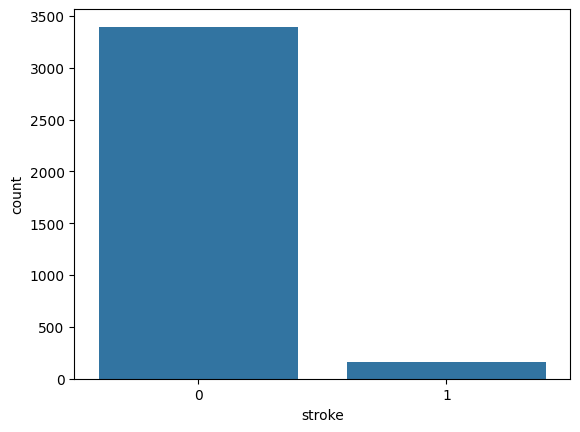

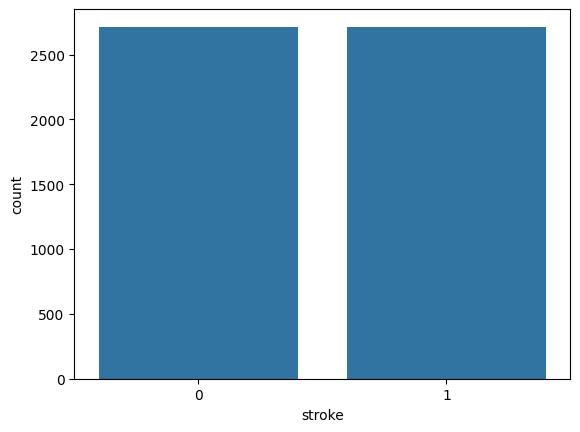

In [304]:
sns.countplot(x='stroke', data=df)
plt.figure()
sns.countplot(x='stroke', data=df_balanced)

We can clearly see that the dataset is now balanced. The stroke and non-stroke patients are now equally represented in the train dataset.

<AxesSubplot:xlabel='age_bucket', ylabel='percent'>

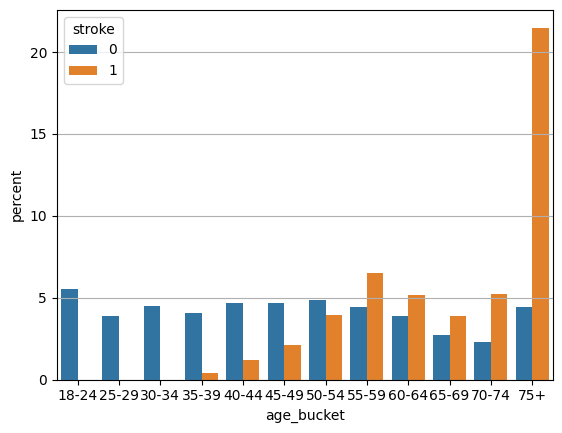

In [305]:
plt.grid()
age_labels = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75+']
dataset_bal_copy = df_balanced.copy()
dataset_bal_copy['age_bucket'] = pd.cut(dataset_bal_copy['age'], bins=[17, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 100], labels=age_labels)
sns.countplot(x='age_bucket', hue='stroke', order=age_labels, data=dataset_bal_copy, stat='percent')

As also observed in the paper, the number of elderly patients who had a stroke is higher than the number of young patients who had a stroke. This is a common observation in the medical field.

<AxesSubplot:xlabel='hypertension', ylabel='percent'>

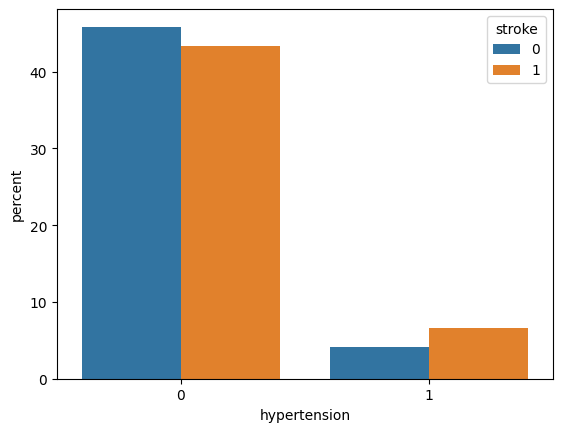

In [306]:
sns.countplot(x='hypertension', hue='stroke', data=df_balanced, stat='percent')

<AxesSubplot:xlabel='heart-disease', ylabel='percent'>

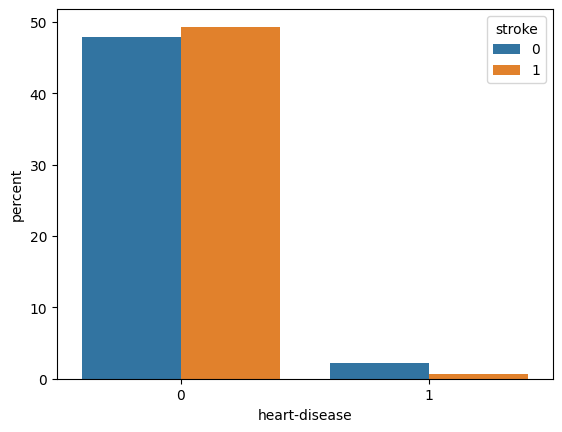

In [307]:
sns.countplot(x='heart-disease', hue='stroke', data=df_balanced, stat='percent')

The fact that the heart disesase class seem not to contribute significantly to the model is also observed in the paper. The authors explain it as a possible consequence of the lack of screening. When hearth diseases are not found, they can not be acted on.

<AxesSubplot:xlabel='smoking-status', ylabel='percent'>

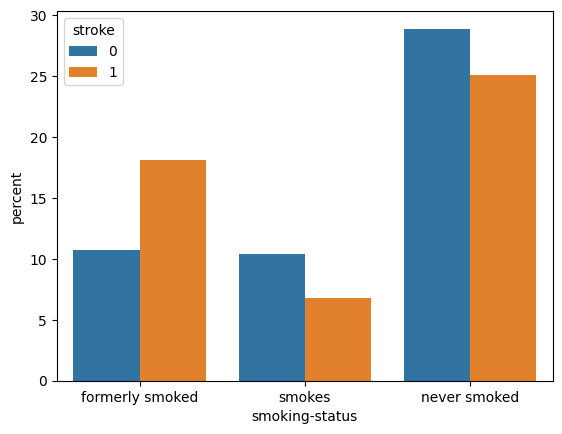

In [308]:
sns.countplot(x='smoking-status', hue='stroke', data=df_balanced, stat='percent')

<AxesSubplot:xlabel='bmi_bucket', ylabel='percent'>

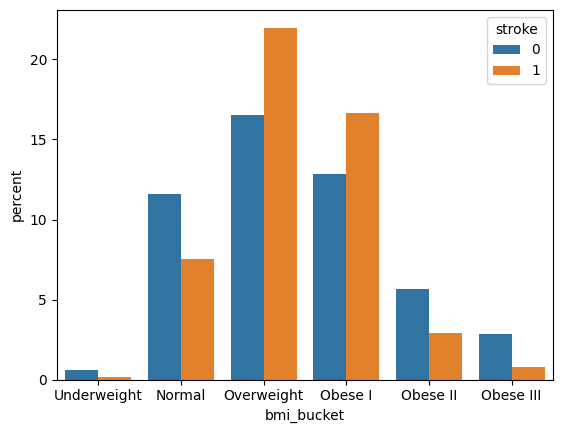

In [309]:
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II', 'Obese III']
dataset_bal_copy['bmi_bucket'] = pd.cut(dataset_bal_copy['bmi'], bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, 100], labels=bmi_labels)
sns.countplot(x='bmi_bucket', hue='stroke',order=bmi_labels,  data=dataset_bal_copy, stat='percent')

<AxesSubplot:xlabel='Residence-type', ylabel='percent'>

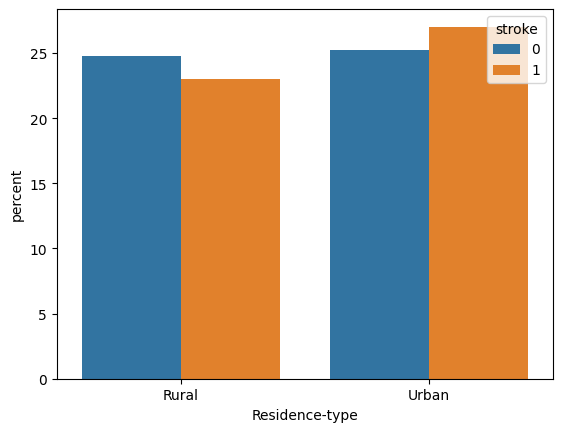

In [310]:
sns.countplot(x='Residence-type', hue='stroke', data=df_balanced, stat='percent')

<AxesSubplot:xlabel='work-type', ylabel='percent'>

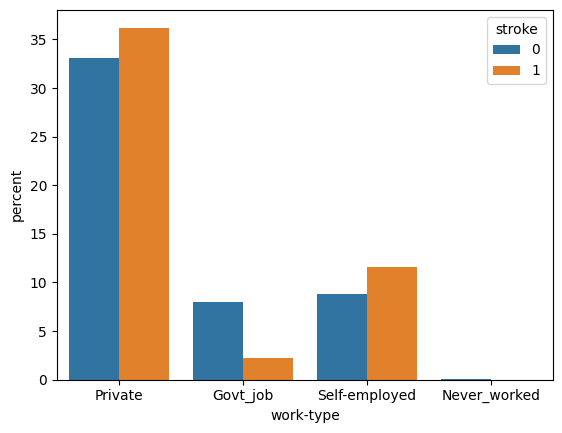

In [311]:
sns.countplot(x='work-type', hue='stroke', data=df_balanced, stat='percent')

The private sector seems to have a higher number of stroke patients.

<AxesSubplot:xlabel='gender', ylabel='percent'>

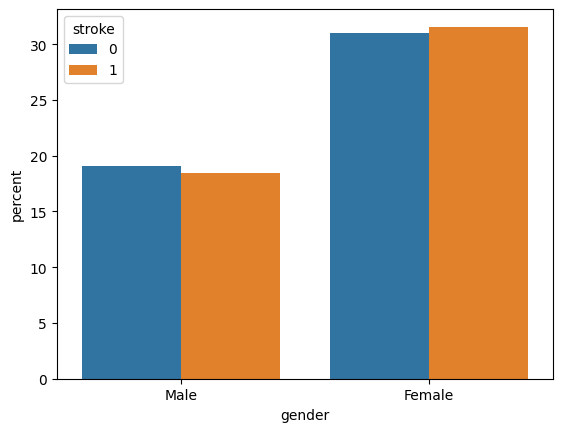

In [312]:
sns.countplot(x='gender', hue='stroke', data=df_balanced, stat='percent')

Before proceding, we may also visualize the features correlation with a heatmap

In [313]:
df_balanced.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status,stroke
0,Male,59.0,0,0,Yes,Private,Rural,69.37,26.9,formerly smoked,0
1,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0
2,Male,48.0,0,0,No,Govt_job,Urban,84.20,29.7,never smoked,1
3,Male,37.0,0,0,Yes,Private,Urban,79.56,25.2,never smoked,0
4,Male,40.0,0,0,Yes,Self-employed,Rural,65.29,28.3,never smoked,0


By plotting the correlation between the features, we can see that there is no strong correlation between the features. This is good because it means that the features are independent of each other.

## Feature Ranking

In [314]:
X_train.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status
0,Male,59.0,0,0,Yes,Private,Rural,69.37,26.9,formerly smoked
1,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes
2,Male,48.0,0,0,No,Govt_job,Urban,84.20,29.7,never smoked
3,Male,37.0,0,0,Yes,Private,Urban,79.56,25.2,never smoked
4,Male,40.0,0,0,Yes,Self-employed,Rural,65.29,28.3,never smoked


<AxesSubplot:xlabel='stroke', ylabel='count'>

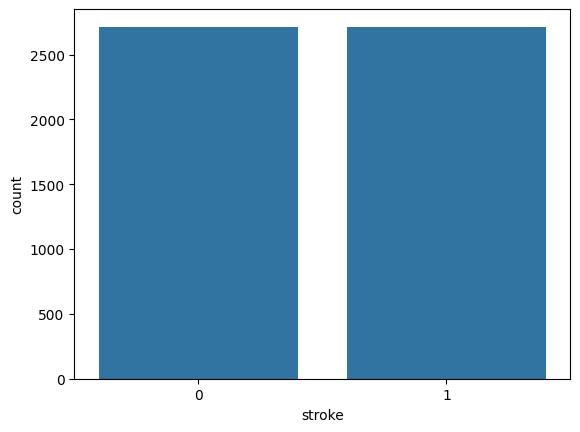

In [315]:
df_train = X_train.copy()
df_train['stroke'] = y_train

sns.countplot(x='stroke', data=df_train)

### Apply the random forest classifier to select the most important features

We start with the preprocessing part

In [316]:
X_tmp = X_train.copy()
y_tmp = y_train.copy()

# Apply one hot encoding to cathegorical features
dummies = pd.get_dummies(X_tmp[cathegorical_features]) 
X_tmp = X_tmp.drop(cathegorical_features, axis=1)
X_tmp = pd.concat([X_tmp, dummies], axis=1)

tmp_features = X_tmp.columns

# Apply ordinal encoding to binary features
oe = OrdinalEncoder()
X_tmp[binary_features] = oe.fit_transform(X_tmp[binary_features])

# Normalize the data
scaler = RobustScaler()
X_tmp = scaler.fit_transform(X_tmp)

We procede training the random forest classifier

{'heart-disease': 0.017614480093820037, 'hypertension': 0.020840119298845997, 'gender': 0.028237003155267473, 'Residence-type': 0.032749138322165, 'smoking-status': 0.041419921324024556, 'work-type': 0.052211442911743754, 'ever-married': 0.0523970284642608, 'bmi': 0.15162870531812192, 'avg-glucose-level': 0.20632669956630598, 'age': 0.39657546154544465}


<BarContainer object of 10 artists>

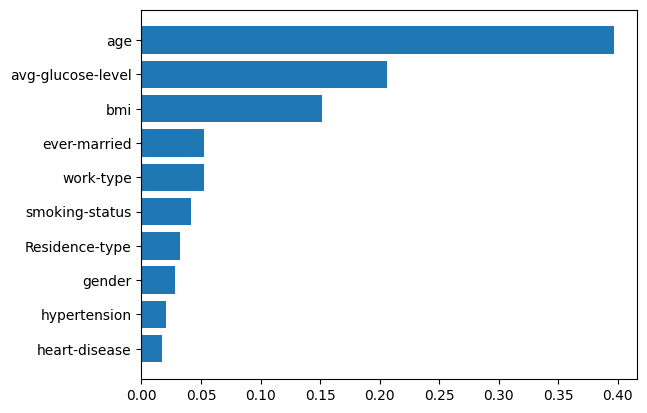

In [317]:
from sklearn.ensemble import RandomForestClassifier

dataset_features = df.columns[:-1]

rf_classifier = RandomForestClassifier(random_state=42)

importances = dict()
for f in dataset_features:
    importances[f] = 0

rf_classifier.fit(X_tmp, y_train)

feature_importance = list(zip(tmp_features, rf_classifier.feature_importances_))

for f in dataset_features:
    for f2, imp in feature_importance:
        if f in f2:
            importances[f] += imp
    

importances = dict(sorted(importances.items(), key=lambda item: item[1]))
print(importances)    
plt.barh([k for k, _ in importances.items()],[v for _, v in importances.items()])

We continue with the feature ranking

{'hypertension': 0.0, 'Residence-type': 0.0003209266967276747, 'gender': 0.001453726674587763, 'heart-disease': 0.016870228739164883, 'smoking-status': 0.017287587817683248, 'work-type': 0.03441825657301245, 'avg-glucose-level': 0.044407383006991985, 'ever-married': 0.06195996232036838, 'bmi': 0.4307600376556333, 'age': 0.5197169071347214}


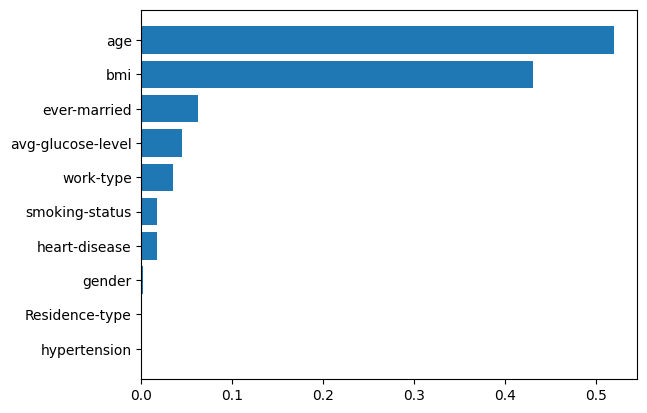

In [318]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_tmp, y_tmp, random_state=42)

feature_importance = list(zip(tmp_features, mi))
importances = dict()
for f in dataset_features:
    importances[f] = 0

for f in dataset_features:
    for f2, imp in feature_importance:
        if f in f2:
            importances[f] += imp


importances = dict(sorted(importances.items(), key=lambda item: item[1]))            
plt.barh([k for k, _ in importances.items()],[v for _, v in importances.items()])
print(importances)

Both models predict Age to be the the most influent feature in the prediction of stroke. This is consistent with the paper. Also hypertension is among the least important features in both models. This is also consistent with the paper.

## Model training

In this section we will train each model, as specified by the paper and we will compute the specified metrics.

In [319]:
# metrics list
confusion_matrices = dict()
cross_val_scores_mean = dict()
accuracy = dict()
precision = dict()
recall = dict()

F_metric = dict()
auc_score = dict()

In [320]:
print(X_train.shape)
X_train.head()

(5430, 10)


,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status
0,Male,59.0,0,0,Yes,Private,Rural,69.37,26.9,formerly smoked
1,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes
2,Male,48.0,0,0,No,Govt_job,Urban,84.20,29.7,never smoked
3,Male,37.0,0,0,Yes,Private,Urban,79.56,25.2,never smoked
4,Male,40.0,0,0,Yes,Self-employed,Rural,65.29,28.3,never smoked


In [321]:
print(X_test.shape)
X_test.head()

(713, 10)


,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status
3330,Female,56.0,0,0,Yes,Private,Urban,80.08,25.6,never smoked
1291,Female,50.0,0,0,Yes,Govt_job,Urban,74.72,28.5,never smoked
2275,Female,82.0,0,0,Yes,Self-employed,Rural,117.75,29.8,never smoked
1677,Female,54.0,0,0,Yes,Private,Urban,75.09,38.9,formerly smoked
1566,Male,76.0,0,1,Yes,Self-employed,Rural,101.43,29.1,never smoked


In [322]:
from sklearn.model_selection import GridSearchCV, GroupShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import make_scorer

processor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('bool', OneHotEncoder(categories=[[0, 1], [0, 1], ['Male', 'Female'], ['Yes', 'No'], ['Urban', 'Rural']]), binary_features),
        ('cat', OneHotEncoder(categories=[['Private', 'Self-employed', 'Govt_job', 'Never_worked'], ['smokes', 'never smoked', 'formerly smoked']]), cathegorical_features)])

scaler = ColumnTransformer(
    transformers=[
        ('num_scale', StandardScaler(), [1, 7, 8])
    ],
    remainder='passthrough')

grid_models = [
               ('Naive Bayes', GaussianNB(),[{'var_smoothing': [1e-08, 1e-07, 1e-06]}]),
               ('Logistic Regression', LogisticRegression(),[{'C':[0.25,0.5,0.75,1],'random_state':[0], 'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'max_iter':[1000]}]),
               ('SGD', SGDClassifier(), [{'loss': ['hinge', 'log_loss', 'modified_huber'],'penalty': ['l2', 'l1', 'elasticnet'],'alpha': [0.0001, 0.001, 0.01, 0.1]}]),
               ('KNN', KNeighborsClassifier(),[{'n_neighbors':[3,5,7,8,10], 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'], 'weights': ['uniform', 'distance']}]), 
               ('Decision Tree', DecisionTreeClassifier(),[{'criterion':['gini','entropy'],'random_state':[0]}]), 
               ('Random Forest', RandomForestClassifier(),[{'n_estimators':[100,150,200],'criterion':['gini','entropy'],'random_state':[0]}]),
               ('MLP', MLPClassifier(),[{'hidden_layer_sizes':[(10,),(20,), (25,)],'max_iter':[500],'learning_rate':['constant'], 'learning_rate_init':[0.003, 0.03, 0.3], 'momentum':[0.02,0.2], 'activation': ['relu', 'tanh']}])
               ]

# The scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}
# dictionary to store the trained models, with the best hyperparameters
models = dict()

for k, m, param_grid in grid_models:
    grid = GridSearchCV(estimator=m, param_grid = param_grid, scoring = scoring, cv = 10, refit='roc_auc') # f1 score is used as scoring metric, because it is the harmonic mean of precision and recall

    pipeline = Pipeline([
        ('processor', processor),
        ('scaler', scaler),
        ('model', grid)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results = grid.cv_results_
    best_accuracy = grid.best_score_
    best_param = grid.best_params_


    for scorer in scoring:
        best_index = results['rank_test_' + scorer].argmin()
        print(f"Best {scorer} score - cross validated: {results['mean_test_' + scorer][best_index]:.2f} (std: {results['std_test_' + scorer][best_index]:.2f})")

    cross_val_scores_mean[k] = best_accuracy

    confusion_matrices[k] = confusion_matrix(y_test, y_pred)
    accuracy[k] = accuracy_score(y_test, y_pred)
    precision[k] = precision_score(y_test, y_pred)
    recall[k] = recall_score(y_test, y_pred)
    F_metric[k] = f1_score(y_test, y_pred)
    auc_score[k] = roc_auc_score(y_test, y_pred)

    models[k] = pipeline  # save the model with the best hyperparameters
    
    print('Best Parameters : ',best_param)
    print('')
    
    print("10-fold cross validation score: ", cross_val_scores_mean[k])
    print("Accuracy: ", accuracy[k])
    print("Precision: ", precision[k])
    print("Recall: ", recall[k])
    print("F1 score: ", F_metric[k])
    print("AUC: ", auc_score[k])
    print('')
    print(classification_report(y_test, y_pred))
    print('----------------')
    print('')

Best accuracy score - cross validated: 0.70 (std: 0.02)
Best precision score - cross validated: 0.64 (std: 0.01)
Best recall score - cross validated: 0.93 (std: 0.04)
Best f1 score - cross validated: 0.75 (std: 0.02)
Best roc_auc score - cross validated: 0.70 (std: 0.02)
Best Parameters :  {'var_smoothing': 1e-06}

10-fold cross validation score:  0.6961118949424787
Accuracy:  0.4670406732117812
Precision:  0.05141388174807198
Recall:  0.6451612903225806
F1 score:  0.09523809523809523
AUC:  0.5520527859237536

              precision    recall  f1-score   support

           0       0.97      0.46      0.62       682
           1       0.05      0.65      0.10        31

    accuracy                           0.47       713
   macro avg       0.51      0.55      0.36       713
weighted avg       0.93      0.47      0.60       713

----------------

Best accuracy score - cross validated: 0.77 (std: 0.02)
Best precision score - cross validated: 0.75 (std: 0.01)
Best recall score - cross 

In [323]:
models_optimal = {
    'Naive Bayes': GaussianNB(var_smoothing=1e-07),
    'Logistic Regression': LogisticRegression(C=0.25, random_state=0, solver='liblinear', max_iter=1000),
    'SGD': SGDClassifier(alpha=0.1, loss='hinge', penalty='l2'),
    'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance'),
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', random_state=0),
    'Random Forest': RandomForestClassifier(random_state=0, criterion='entropy', n_estimators=200),
    'MLP': MLPClassifier(learning_rate='constant', learning_rate_init=0.003, momentum=0.2, activation='tanh', max_iter=500, hidden_layer_sizes=(25,))
}

In [324]:
# define the base models
base_models_stacking = [
    ('rf', RandomForestClassifier(criterion='gini', n_estimators=200, random_state=0)),
    ('nb', GaussianNB(var_smoothing=1e-07)),
    ('dt1', DecisionTreeClassifier(criterion='gini', random_state=0)),
    ('dt2', DecisionTreeClassifier(criterion='entropy', random_state=0)),
]
base_models_voting = [
    ('rf', RandomForestClassifier(criterion='gini', n_estimators=200, random_state=0)),
    ('dt1', DecisionTreeClassifier(criterion='gini', random_state=0)),
    ('dt2', DecisionTreeClassifier(criterion='entropy', random_state=0)),
]

# Define the meta-model for stacking
meta_model = LogisticRegression(C=0.75, random_state=0, solver='lbfgs', max_iter=500)

stacking = StackingClassifier(estimators=base_models_stacking, final_estimator=meta_model, cv=10)
voting = VotingClassifier(estimators=base_models_voting, voting='hard') # in the paper the voting is hard

pipeline_stack = Pipeline([
        ('processor', processor),
        ('scaler', scaler),
        ('model', stacking)
    ])

pipeline_vote = Pipeline([
        ('processor', processor),
        ('scaler', scaler),
        ('model', voting)
    ])


# Evaluating the stacking method
models['stacking'] = pipeline_stack.fit(X_train, y_train)

y_pred = pipeline_stack.predict(X_test)

cross_val_scores_mean['stacking'] = cross_val_score(pipeline_stack, X_train, y_train, cv=10).mean()

confusion_matrices['stacking'] = confusion_matrix(y_test, y_pred)
accuracy['stacking'] = accuracy_score(y_test, y_pred)
precision['stacking'] = precision_score(y_test, y_pred)
recall['stacking'] = recall_score(y_test, y_pred)
F_metric['stacking'] = f1_score(y_test, y_pred)
auc_score['stacking'] = roc_auc_score(y_test, y_pred)

print("Model: Stacking")
print("10-fold cross validation score: ", cross_val_scores_mean['stacking'])
print("Accuracy: ", accuracy['stacking'])
print("Precision: ", precision['stacking'])
print("Recall: ", recall['stacking'])
print("F1 score: ", F_metric['stacking'])
print("AUC: ", auc_score['stacking'])


# Evaluating the Majority voting
models['voting'] = pipeline_vote.fit(X_train, y_train)

y_pred = pipeline_vote.predict(X_test)

cross_val_scores_mean['voting'] = cross_val_score(pipeline_vote, X_train, y_train, cv=10).mean()

confusion_matrices['voting'] = confusion_matrix(y_test, y_pred)
accuracy['voting'] = accuracy_score(y_test, y_pred)
precision['voting'] = precision_score(y_test, y_pred)
recall['voting'] = recall_score(y_test, y_pred)
F_metric['voting'] = f1_score(y_test, y_pred)
auc_score['voting'] = roc_auc_score(y_test, y_pred)
print('---------------------------------------------')
print('')
print("Model: Majority Voting")
print("10-fold cross validation score: ", cross_val_scores_mean['voting'])
print("Accuracy: ", accuracy['voting'])
print("Precision: ", precision['voting'])
print("Recall: ", recall['voting'])
print("F1 score: ", F_metric['voting'])
print("AUC: ", auc_score['voting'])

Model: Stacking
10-fold cross validation score:  0.9486187845303867
Accuracy:  0.9144460028050491
Precision:  0.058823529411764705
Recall:  0.06451612903225806
F1 score:  0.06153846153846154
AUC:  0.5087976539589443
---------------------------------------------

Model: Majority Voting
10-fold cross validation score:  0.9302025782688765
Accuracy:  0.8920056100981767
Precision:  0.057692307692307696
Recall:  0.0967741935483871
F1 score:  0.07228915662650602
AUC:  0.5124633431085043


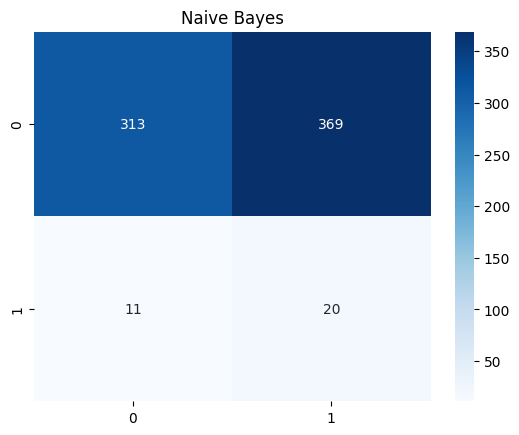

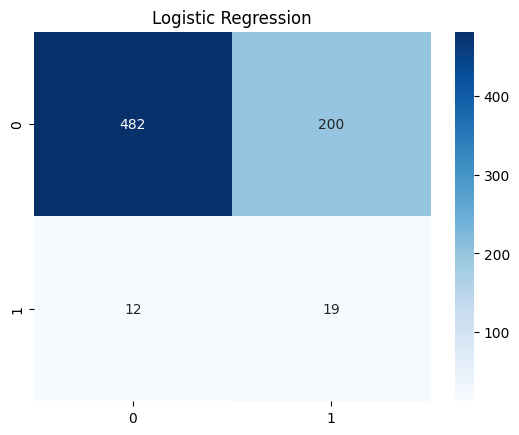

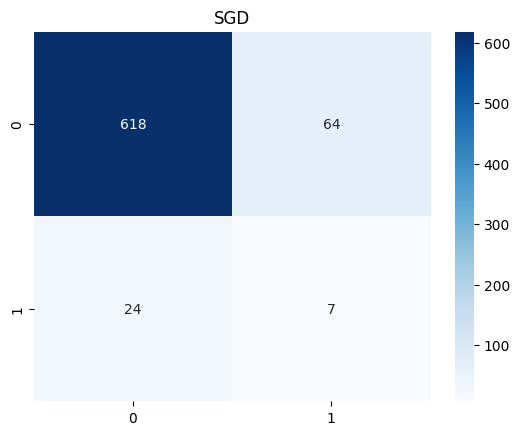

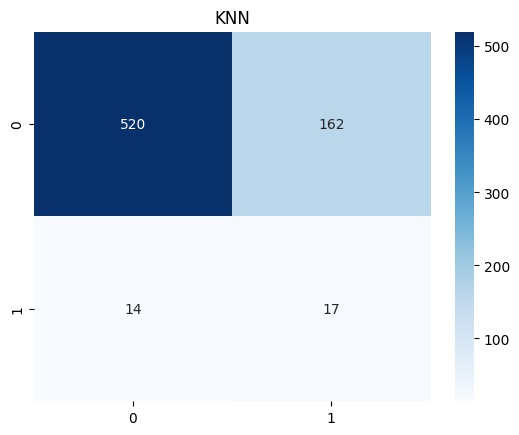

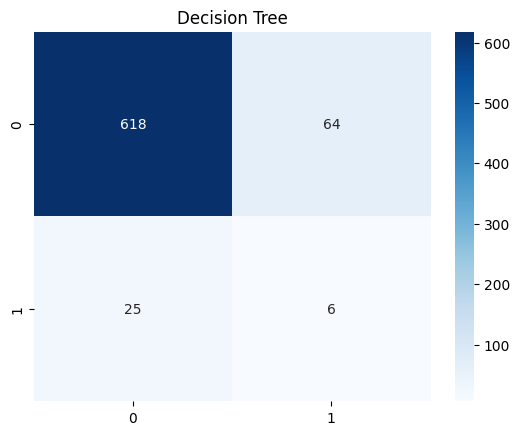

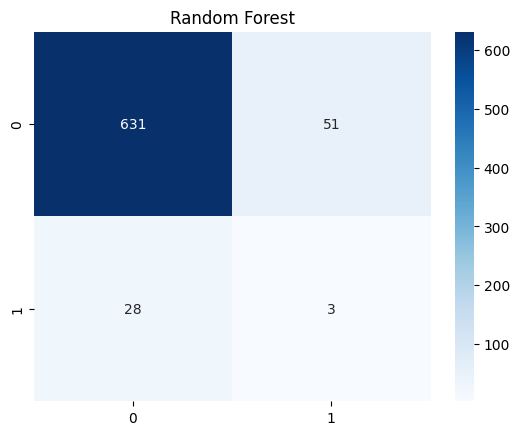

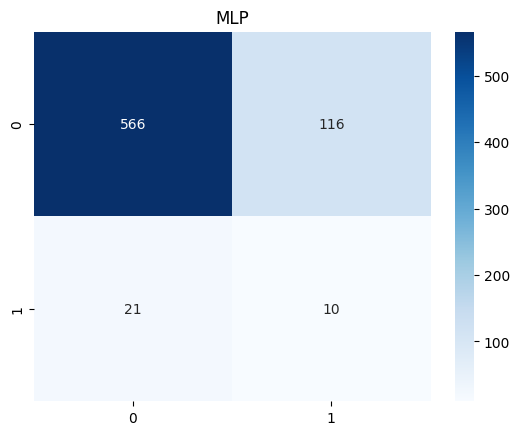

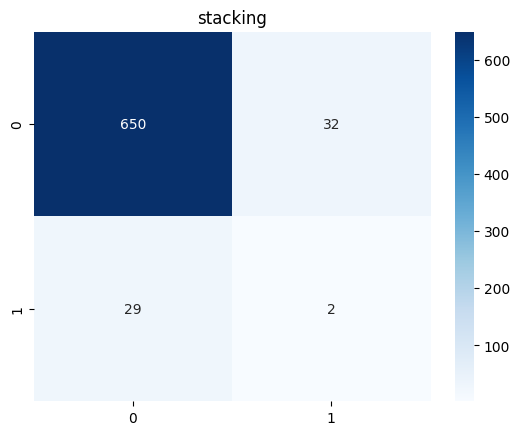

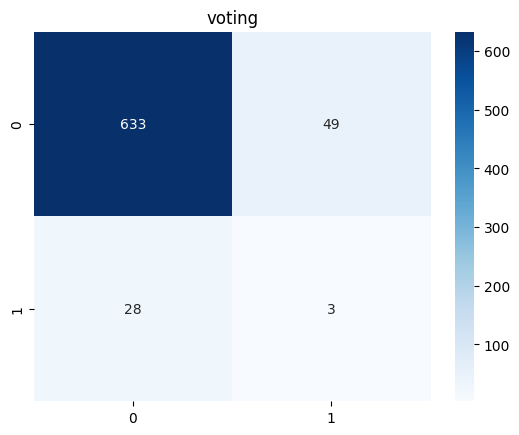

In [325]:
for k, m in confusion_matrices.items():
    plt.figure()
    plt.title(k)
    sns.heatmap(m, annot=True, fmt='d', cmap='Blues')

The following confusion matrices make us realize that the models are not performing well. This is because the dataset that we have been using is imbalanced, and while we have balanced it for the training phase, in the prediction phase, when the data used for testing remains unbalanced, the models are not able to predict the stroke cases correctly and produce many false negatives.

Text(0.5, 1.0, 'AUC')

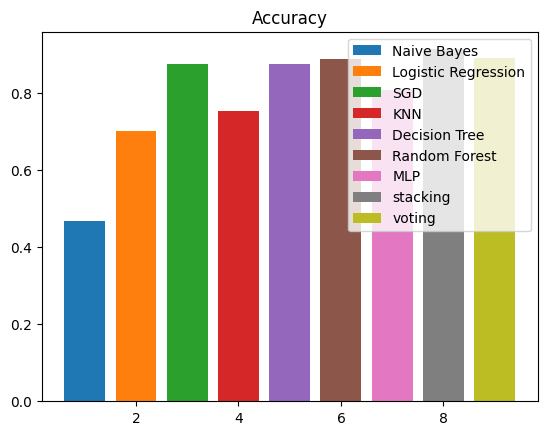

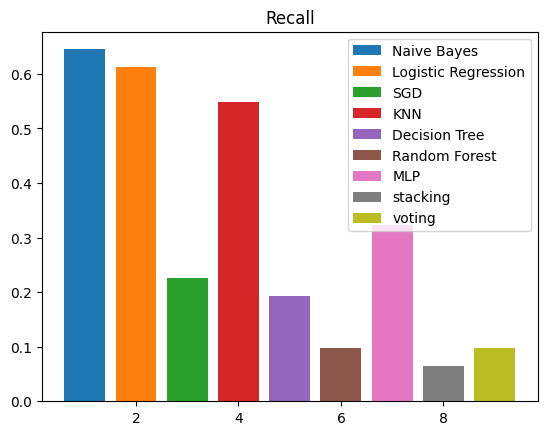

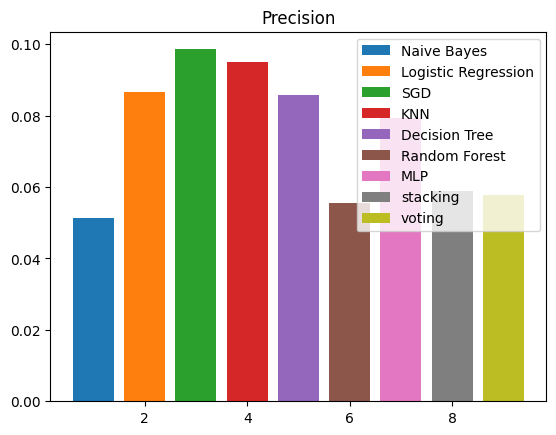

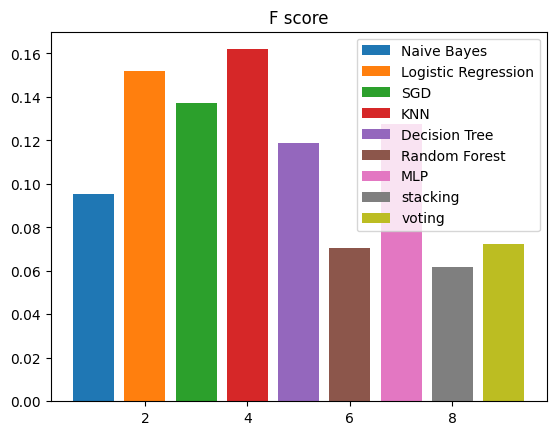

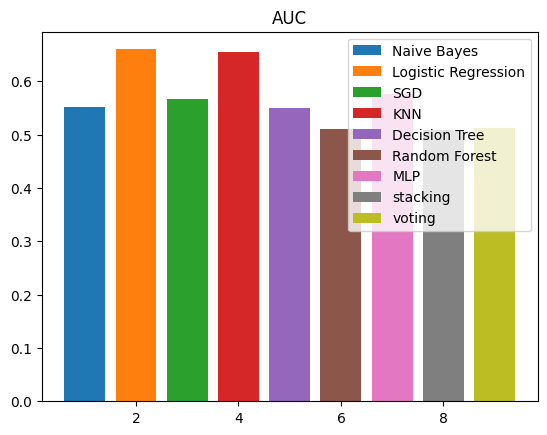

In [326]:
## Accuracy
plt.figure()
i=1
for k, v in accuracy.items():
    plt.bar(i, v, label = k)
    i+=1

plt.legend()
plt.title("Accuracy")

## Recall
plt.figure()
i=1
for k, v in recall.items():
    plt.bar(i, v, label = k)
    i+=1

plt.legend()
plt.title("Recall")

## Precision
plt.figure()
i=1
for k, v in precision.items():
    plt.bar(i, v, label = k)
    i+=1

plt.legend()
plt.title("Precision")

## F score
plt.figure()
i=1
for k, v in F_metric.items():
    plt.bar(i, v, label = k)
    i+=1

plt.legend()
plt.title("F score")

## AUC
plt.figure()
i=1
for k, v in auc_score.items():
    plt.bar(i, v, label = k)
    i+=1

plt.legend()
plt.title("AUC")

<AxesSubplot:>

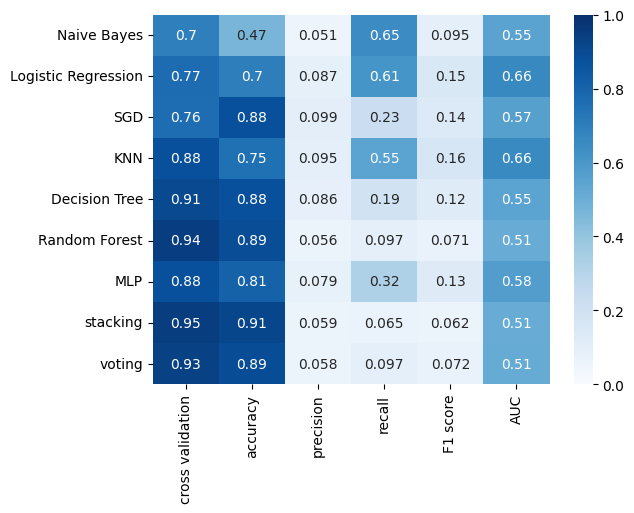

In [327]:
model_matrix = dict()

for k in models.keys():
    model_matrix[k] = list()
    model_matrix[k].append(cross_val_scores_mean[k])
    model_matrix[k].append(accuracy[k])
    model_matrix[k].append(precision[k])
    model_matrix[k].append(recall[k])
    model_matrix[k].append(F_metric[k])
    model_matrix[k].append(auc_score[k])


matrix = pd.DataFrame(model_matrix, index=['cross validation', 'accuracy', 'precision', 'recall', 'F1 score', 'AUC']).T

sns.heatmap(matrix, annot = True, vmin=0, vmax=1, cmap='Blues')